# 1. Dask

## 1.1 Delayed parallelize - for functions

In [1]:
from dask.distributed import Client
client = Client(n_workers = 4)

In [2]:
from time import sleep 

def inc(x):
    sleep(1)
    return x + 1
def add(x,y):
    sleep(1)
    return x + y

In [3]:
%%time 

x = inc(1)
y = inc(2)
z = add(x,y)

CPU times: user 106 ms, sys: 19.4 ms, total: 126 ms
Wall time: 3.01 s


In [4]:
from dask import delayed 

In [5]:
%%time 

x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x,y)

CPU times: user 676 µs, sys: 539 µs, total: 1.21 ms
Wall time: 899 µs


In [6]:
%%time 
z.compute()

CPU times: user 83.1 ms, sys: 14.5 ms, total: 97.6 ms
Wall time: 2.03 s


5

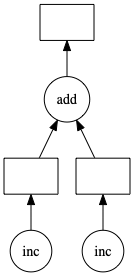

In [7]:
z.visualize()

### Parallelize for loop 

In [8]:
data = [1,2,3,4,5,6,7,8]

In [9]:
%%time 

results = []
for x in data:
    y = inc(x)
    results.append(y)
total = sum(results)

CPU times: user 386 ms, sys: 68.8 ms, total: 455 ms
Wall time: 8.03 s


In [10]:
%%time

results = []
for x in data:
    y = delayed(inc)(x)
    results.append(y)
total = delayed(sum)(results)

CPU times: user 1.87 ms, sys: 1.45 ms, total: 3.32 ms
Wall time: 2.28 ms


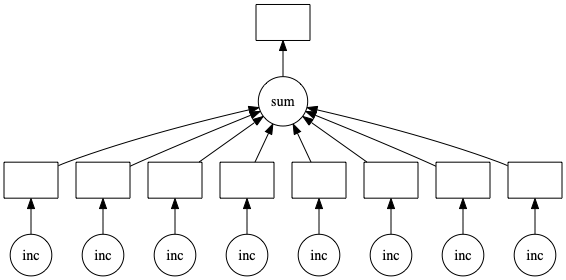

In [11]:
total.visualize()

### Parallelize for loop with control flow

In [12]:
def double(x):
    sleep(1)
    return 2 * x
def is_even(x):
    return not x % 2
data = [1,2,3,4,5,6,7,8,9,10]

In [13]:
%%time 

results = []
for x in data:
    if is_even(x):
        y = double(x)
    else:
        y = inc(x)
    results.append(y)
total = sum(results)

CPU times: user 486 ms, sys: 85.9 ms, total: 572 ms
Wall time: 10 s


In [14]:
%%time 

results = []
for x in data:
    if is_even(x):
        y = delayed(double)(x)
    else:
        y = delayed(inc)(x)
    results.append(y)
total = delayed(sum)(results)

CPU times: user 1.6 ms, sys: 1.12 ms, total: 2.71 ms
Wall time: 1.9 ms


In [15]:
total.compute()

90

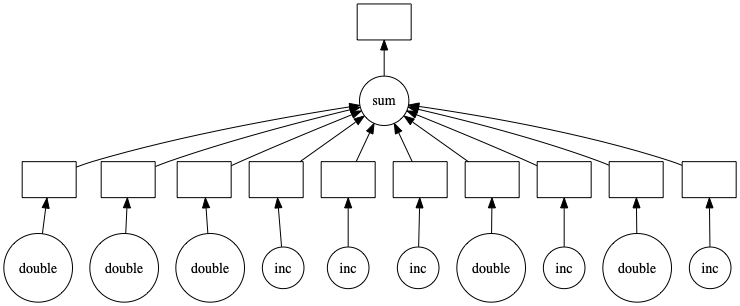

In [16]:
total.visualize()

### Parallelize pandas GroupBy reduction

In [17]:
%run prep.py -d flights

In [18]:
import os
sorted(os.listdir(os.path.join('data','nycflights')))

['1990.csv',
 '1991.csv',
 '1992.csv',
 '1993.csv',
 '1994.csv',
 '1995.csv',
 '1996.csv',
 '1997.csv',
 '1998.csv',
 '1999.csv']

In [19]:
import pandas as pd
df = pd.read_csv(os.path.join('data','nycflights','1990.csv'))
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990,1,1,1,1621.0,1540,1747.0,1701,US,33,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990,1,2,2,1547.0,1540,1700.0,1701,US,33,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990,1,3,3,1546.0,1540,1710.0,1701,US,33,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990,1,4,4,1542.0,1540,1710.0,1701,US,33,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990,1,5,5,1549.0,1540,1706.0,1701,US,33,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [20]:
df.groupby('Origin').DepDelay.mean()

Origin
EWR     9.168411
JFK    11.857274
LGA     8.560045
Name: DepDelay, dtype: float64

In [21]:
from glob import glob 
filenames = sorted(glob(os.path.join('data','nycflights','*.csv')))
filenames

['data/nycflights/1990.csv',
 'data/nycflights/1991.csv',
 'data/nycflights/1992.csv',
 'data/nycflights/1993.csv',
 'data/nycflights/1994.csv',
 'data/nycflights/1995.csv',
 'data/nycflights/1996.csv',
 'data/nycflights/1997.csv',
 'data/nycflights/1998.csv',
 'data/nycflights/1999.csv']

In [22]:
%%time 

sums = []
counts = []

for fn in filenames:
    df = pd.read_csv(fn)
    by_origin = df.groupby('Origin')
    total = by_origin.DepDelay.sum()
    count = by_origin.DepDelay.count()
    sums.append(total)
    counts.append(count)
    
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights
mean

CPU times: user 3.41 s, sys: 515 ms, total: 3.92 s
Wall time: 3.86 s


Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

In [23]:
from dask import compute

In [24]:
%%time 

sums = []
counts = []

for fn in filenames:
    df = delayed(pd.read_csv)(fn)
    by_origin = df.groupby('Origin')
    total = by_origin.DepDelay.sum()
    count = by_origin.DepDelay.count()
    sums.append(total)
    counts.append(count)
sums, counts = compute(sums, counts)
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights
mean

CPU times: user 163 ms, sys: 19.7 ms, total: 182 ms
Wall time: 1.48 s


Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

In [25]:
client.close()

## 1.2 Lazy execution

### Graph execution engine 

In [26]:
from dask import delayed 

@delayed
def inc(x):
    return x + 1

@delayed 
def add(x, y):
    return x + y

In [27]:
x = inc(15)
y = inc(30)
total = add(x, y)
total

Delayed('add-f5ef0cd6-dafa-4a66-81a1-3e28613d3094')

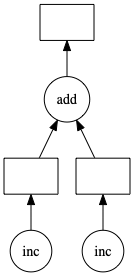

In [28]:
total.visualize()

In [29]:
total.compute()

47

### Data processing example

In [30]:
%run prep.py -d accounts

In [31]:
import pandas as pd
import os

filenames = [os.path.join('data','accounts.%d.csv' % i) for i in [0,1,2]]
filenames

['data/accounts.0.csv', 'data/accounts.1.csv', 'data/accounts.2.csv']

In [32]:
%%time 
a = pd.read_csv(filenames[0])
b = pd.read_csv(filenames[1])
c = pd.read_csv(filenames[2])

na = len(a)
nb = len(b)
nc = len(c)

total = sum([na,nb,nc])
print(total)

3000000
CPU times: user 550 ms, sys: 83.4 ms, total: 634 ms
Wall time: 636 ms


In [33]:
%%time 
a = delayed(pd.read_csv)(filenames[0])
b = delayed(pd.read_csv)(filenames[1])
c = delayed(pd.read_csv)(filenames[2])

na = delayed(len)(a)
nb = delayed(len)(b)
nc = delayed(len)(c)

total = delayed(sum)([na,nb,nc])
print(total.compute())

3000000
CPU times: user 578 ms, sys: 112 ms, total: 690 ms
Wall time: 309 ms


In [34]:
%%time 
csvs = [delayed(pd.read_csv)(fn) for fn in filenames]
lens = [delayed(len)(csv) for csv in csvs]
total = delayed(sum)(lens)
print(total.compute())

3000000
CPU times: user 571 ms, sys: 116 ms, total: 687 ms
Wall time: 321 ms


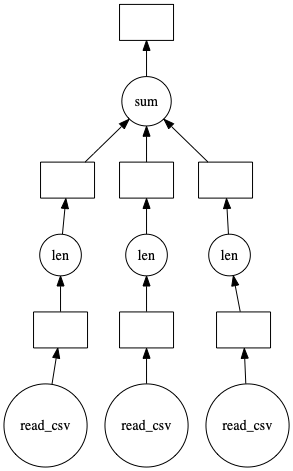

In [35]:
total.visualize()

## 1.3 Bag - parallel lists for semi-structured data

### Create

In [36]:
%run prep.py -d accounts

In [37]:
from dask.distributed import Client 
client = Client(n_workers = 4)

In [38]:
import dask.bag as db 
b = db.from_sequence([1,2,3,4,5,6,7,8,9,10], npartitions = 2)
b.take(3)

(1, 2, 3)

In [39]:
import os
b = db.read_text(os.path.join('data','accounts.*.json.gz'))
b.take(1)[0]

'{"id": 0, "name": "Hannah", "transactions": [{"transaction-id": 791, "amount": -574}, {"transaction-id": 1407, "amount": -495}, {"transaction-id": 1524, "amount": -727}, {"transaction-id": 1640, "amount": -661}, {"transaction-id": 1695, "amount": -737}, {"transaction-id": 1706, "amount": -768}, {"transaction-id": 2552, "amount": -624}, {"transaction-id": 4078, "amount": -643}, {"transaction-id": 4193, "amount": -678}, {"transaction-id": 4305, "amount": -590}, {"transaction-id": 4342, "amount": -696}, {"transaction-id": 5162, "amount": -706}, {"transaction-id": 5367, "amount": -519}, {"transaction-id": 6837, "amount": -727}, {"transaction-id": 7228, "amount": -693}, {"transaction-id": 7773, "amount": -761}, {"transaction-id": 8949, "amount": -724}, {"transaction-id": 8985, "amount": -694}, {"transaction-id": 10572, "amount": -569}, {"transaction-id": 10875, "amount": -574}, {"transaction-id": 11190, "amount": -568}, {"transaction-id": 11334, "amount": -680}, {"transaction-id": 12318, "

In [40]:
import sources
sources.bag_url

's3://dask-data/nyc-taxi/2015/yellow_tripdata_2015-01.csv'

### Manipulate

In [41]:
def is_even(n):
    return n % 2 == 0
b = db.from_sequence([1,2,3,4,5,6,7,8,9,10])
c = b.filter(is_even).map(lambda x: x ** 2)
c

dask.bag<lambda, npartitions=10>

In [42]:
c.compute()

[4, 16, 36, 64, 100]

In [43]:
filename = os.path.join('data','accounts.*.json.gz')
lines = db.read_text(filename)
lines.take(3)[0]

'{"id": 0, "name": "Hannah", "transactions": [{"transaction-id": 791, "amount": -574}, {"transaction-id": 1407, "amount": -495}, {"transaction-id": 1524, "amount": -727}, {"transaction-id": 1640, "amount": -661}, {"transaction-id": 1695, "amount": -737}, {"transaction-id": 1706, "amount": -768}, {"transaction-id": 2552, "amount": -624}, {"transaction-id": 4078, "amount": -643}, {"transaction-id": 4193, "amount": -678}, {"transaction-id": 4305, "amount": -590}, {"transaction-id": 4342, "amount": -696}, {"transaction-id": 5162, "amount": -706}, {"transaction-id": 5367, "amount": -519}, {"transaction-id": 6837, "amount": -727}, {"transaction-id": 7228, "amount": -693}, {"transaction-id": 7773, "amount": -761}, {"transaction-id": 8949, "amount": -724}, {"transaction-id": 8985, "amount": -694}, {"transaction-id": 10572, "amount": -569}, {"transaction-id": 10875, "amount": -574}, {"transaction-id": 11190, "amount": -568}, {"transaction-id": 11334, "amount": -680}, {"transaction-id": 12318, "

In [44]:
import json 
js = lines.map(json.loads)
js.take(3)[0]

{'id': 0,
 'name': 'Hannah',
 'transactions': [{'transaction-id': 791, 'amount': -574},
  {'transaction-id': 1407, 'amount': -495},
  {'transaction-id': 1524, 'amount': -727},
  {'transaction-id': 1640, 'amount': -661},
  {'transaction-id': 1695, 'amount': -737},
  {'transaction-id': 1706, 'amount': -768},
  {'transaction-id': 2552, 'amount': -624},
  {'transaction-id': 4078, 'amount': -643},
  {'transaction-id': 4193, 'amount': -678},
  {'transaction-id': 4305, 'amount': -590},
  {'transaction-id': 4342, 'amount': -696},
  {'transaction-id': 5162, 'amount': -706},
  {'transaction-id': 5367, 'amount': -519},
  {'transaction-id': 6837, 'amount': -727},
  {'transaction-id': 7228, 'amount': -693},
  {'transaction-id': 7773, 'amount': -761},
  {'transaction-id': 8949, 'amount': -724},
  {'transaction-id': 8985, 'amount': -694},
  {'transaction-id': 10572, 'amount': -569},
  {'transaction-id': 10875, 'amount': -574},
  {'transaction-id': 11190, 'amount': -568},
  {'transaction-id': 11334, '

In [45]:
js.filter(lambda record: record['name'] == 'Alice').take(5)[0]

{'id': 7,
 'name': 'Alice',
 'transactions': [{'transaction-id': 1871, 'amount': 35},
  {'transaction-id': 2755, 'amount': 77},
  {'transaction-id': 3935, 'amount': 122},
  {'transaction-id': 4355, 'amount': 51},
  {'transaction-id': 5441, 'amount': 31},
  {'transaction-id': 5541, 'amount': 35},
  {'transaction-id': 9534, 'amount': 93},
  {'transaction-id': 10338, 'amount': -27},
  {'transaction-id': 10381, 'amount': 13},
  {'transaction-id': 14003, 'amount': 40},
  {'transaction-id': 14424, 'amount': 105},
  {'transaction-id': 15512, 'amount': 15},
  {'transaction-id': 15597, 'amount': 74},
  {'transaction-id': 16733, 'amount': 106},
  {'transaction-id': 18987, 'amount': 43},
  {'transaction-id': 19334, 'amount': 95},
  {'transaction-id': 19667, 'amount': 107},
  {'transaction-id': 20421, 'amount': 118},
  {'transaction-id': 20452, 'amount': 123},
  {'transaction-id': 20861, 'amount': 12},
  {'transaction-id': 21507, 'amount': 73},
  {'transaction-id': 23120, 'amount': 77},
  {'transa

In [46]:
def count_transactions(d):
    return {'name':d['name'], 'count':len(d['transactions'])}

(js.filter(lambda record: record['name'] == 'Alice')
   .map(count_transactions)
   .take(5))

({'name': 'Alice', 'count': 96},
 {'name': 'Alice', 'count': 50},
 {'name': 'Alice', 'count': 329},
 {'name': 'Alice', 'count': 46},
 {'name': 'Alice', 'count': 278})

In [47]:
(js.filter(lambda record: record['name'] == 'Alice')
   .map(count_transactions)
   .pluck('count')
   .take(5))

(96, 50, 329, 46, 278)

In [48]:
(js.filter(lambda record: record['name'] == 'Alice')
   .map(count_transactions)
   .pluck('count')
   .mean()
   .compute())

210.04714285714286

In [49]:
js.filter(lambda record: record['name'] == 'Alice').pluck('transactions').take(3)[0][0]

{'transaction-id': 1871, 'amount': 35}

In [50]:
(js.filter(lambda record: record['name'] == 'Alice')
   .pluck('transactions')
   .flatten()
   .take(3))

({'transaction-id': 1871, 'amount': 35},
 {'transaction-id': 2755, 'amount': 77},
 {'transaction-id': 3935, 'amount': 122})

In [51]:
(js.filter(lambda record: record['name'] == 'Alice')
   .pluck('transactions')
   .flatten()
   .pluck('amount')
   .take(3))

(35, 77, 122)

In [52]:
(js.filter(lambda record: record['name'] == 'Alice')
   .pluck('transactions')
   .flatten()
   .pluck('amount')
   .mean()
   .compute())

825.0621085062537

In [53]:
b = db.from_sequence(['Alice', 'Bob', 'Charlie', 'Dan', 'Edith', 'Frank'])
b.groupby(len).compute()

[(7, ['Charlie']), (3, ['Bob', 'Dan']), (5, ['Alice', 'Edith', 'Frank'])]

In [54]:
b = db.from_sequence(list(range(10)))
b.groupby(lambda x: x % 2).compute()

[(0, [0, 2, 4, 6, 8]), (1, [1, 3, 5, 7, 9])]

In [55]:
b.groupby(lambda x: x % 2).starmap(lambda k, v: (k, max(v))).compute()

[(0, 8), (1, 9)]

In [56]:
is_even = lambda x: x % 2
b.foldby(is_even, binop=max, combine=max).compute()

[(0, 8), (1, 9)]

### to DataFrames

In [57]:
df1 = js.to_dataframe()
df1.head()

,id,name,transactions
0,0,Hannah,"[{'transaction-id': 791, 'amount': -574}, {'tr..."
1,1,Edith,"[{'transaction-id': 1853, 'amount': 833}, {'tr..."
2,2,Ray,"[{'transaction-id': 473, 'amount': 7279}, {'tr..."
3,3,Jerry,"[{'transaction-id': 2134, 'amount': 12}, {'tra..."
4,4,George,"[{'transaction-id': 161, 'amount': 2}, {'trans..."


In [58]:
%time df1.groupby('name').id.count().compute().head()

CPU times: user 147 ms, sys: 14.4 ms, total: 161 ms
Wall time: 1.58 s


name
Alice      700
Bob        650
Charlie    900
Dan        750
Edith      700
Name: id, dtype: int64

In [59]:
client.close()

## 1.4 Array - distributed numpy

In [60]:
%run prep.py -d random

In [61]:
from dask.distributed import Client 
client = Client(n_workers = 4)

In [62]:
import h5py
import os

f = h5py.File(os.path.join('data','random.hdf5'), mode = 'r')
dset = f['/x']

In [63]:
sums = []
for i in range(0, 1000000000, 1000000):
    chunk = dset[i: i + 1000000]
    sums.append(chunk.sum())
    
total = sum(sums)
total

999985107.625

In [64]:
sums = []
lengths = []
for i in range(0, 1000000000, 1000000):
    chunk = dset[i: i + 1000000] 
    sums.append(chunk.sum())
    lengths.append(len(chunk))

total = sum(sums)
length = sum(lengths)
print(total / length)

0.999985107625


### Blocked algorithms

In [65]:
import dask.array as da
x = da.from_array(dset, chunks = (1000000,))
x

,Array,Chunk
Bytes,4.00 GB,4.00 MB
Shape,"(1000000000,)","(1000000,)"
Count,1001 Tasks,1000 Chunks
Type,float32,numpy.ndarray


In [66]:
result = x.sum()
result

dask.array<sum-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>

In [67]:
result.compute()

Task was destroyed but it is pending!
task: <Task pending name='Task-56' coro=<HTTP1ServerConnection._server_request_loop() running at /Users/boyuan/anaconda3/envs/sds/lib/python3.8/site-packages/tornado/http1connection.py:817> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x7f80c45ba3a0>()]> cb=[IOLoop.add_future.<locals>.<lambda>() at /Users/boyuan/anaconda3/envs/sds/lib/python3.8/site-packages/tornado/ioloop.py:690]>


999985150.0

In [68]:
x.mean().compute()

0.99998516

### Parallelism

In [69]:
import numpy as np 
import dask.array as da

x = da.random.normal(10, 0.1, size = (20000,20000), chunks = (1000, 1000))
y = x.mean(axis = 0)[::100]

In [70]:
x

dask.array<normal, shape=(20000, 20000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [71]:
y

dask.array<getitem, shape=(200,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>

In [72]:
x.nbytes / 1e9

3.2

In [73]:
%%time 
y.compute()

CPU times: user 747 ms, sys: 57.6 ms, total: 805 ms
Wall time: 2.34 s


array([10.00049822, 10.00028481, 10.00003053, 10.00016419,  9.99858547,
        9.99955756,  9.99977412, 10.00133223,  9.9998396 , 10.00011456,
        9.99859404,  9.9996357 ,  9.99959496, 10.00014733, 10.00125243,
       10.00040759, 10.0000251 , 10.00030345,  9.99954262, 10.00019931,
       10.00010135,  9.99976185, 10.00041492, 10.00004262, 10.0006639 ,
        9.99914935,  9.99937156,  9.99983709,  9.99991717,  9.99983294,
       10.00077944, 10.00063314,  9.9996789 , 10.00018874,  9.99966983,
       10.0005286 , 10.00121626, 10.00004849, 10.00009394, 10.00032565,
        9.99981778, 10.0015138 , 10.00038627,  9.99942177,  9.99946421,
        9.99851514, 10.00068455, 10.00066251, 10.00000566, 10.00039764,
       10.00057853,  9.99901984,  9.99986817, 10.00101556, 10.00030631,
        9.99978383, 10.00102576,  9.99882961, 10.00058672, 10.00011449,
       10.00083702, 10.00071986, 10.00029224,  9.99996637,  9.99964319,
       10.00014321, 10.00005763,  9.99997518,  9.99800501,  9.99

In [74]:
client.close()

## 1.5 DataFrame - parallel tabular dataframe


In [75]:
%run prep.py -d flights

In [76]:
import dask 

In [77]:
from dask.distributed import Client 
client = Client(n_workers = 4)

In [78]:
import dask.dataframe as dd

df = dd.read_csv(os.path.join('data','nycflights','*.csv'),
                 parse_dates = {'Date':[0,1,2]})
df

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,float64,int64,float64,int64,object,int64,float64,float64,int64,float64,float64,float64,object,object,float64,float64,float64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [79]:
df.head()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990-01-01,1,1621.0,1540,1747.0,1701,US,33,NaN,86.0,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990-01-02,2,1547.0,1540,1700.0,1701,US,33,NaN,73.0,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990-01-03,3,1546.0,1540,1710.0,1701,US,33,NaN,84.0,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990-01-04,4,1542.0,1540,1710.0,1701,US,33,NaN,88.0,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990-01-05,5,1549.0,1540,1706.0,1701,US,33,NaN,77.0,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [80]:
try:
    df.tail()
except ValueError:
    pass

In [81]:
df = dd.read_csv(os.path.join('data','nycflights','*.csv'),
                 parse_dates = {'Date':[0,1,2]},
                 dtype = {'TailNum':str,
                          'CRSElapsedTime':float,
                          'Cancelled':bool})

In [82]:
df.tail()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
269176,1999-12-27,1,1645.0,1645,1830.0,1901,UA,1753,N516UA,225.0,...,205.0,-31.0,0.0,LGA,DEN,1619.0,7.0,13.0,False,0
269177,1999-12-28,2,1726.0,1645,1928.0,1901,UA,1753,N504UA,242.0,...,214.0,27.0,41.0,LGA,DEN,1619.0,5.0,23.0,False,0
269178,1999-12-29,3,1646.0,1645,1846.0,1901,UA,1753,N592UA,240.0,...,220.0,-15.0,1.0,LGA,DEN,1619.0,5.0,15.0,False,0
269179,1999-12-30,4,1651.0,1645,1908.0,1901,UA,1753,N575UA,257.0,...,233.0,7.0,6.0,LGA,DEN,1619.0,5.0,19.0,False,0
269180,1999-12-31,5,1642.0,1645,1851.0,1901,UA,1753,N539UA,249.0,...,232.0,-10.0,-3.0,LGA,DEN,1619.0,6.0,11.0,False,0


### Computations

In [83]:
%%time 
df.DepDelay.max().compute()

CPU times: user 76 ms, sys: 9.99 ms, total: 86 ms
Wall time: 2.02 s


1435.0

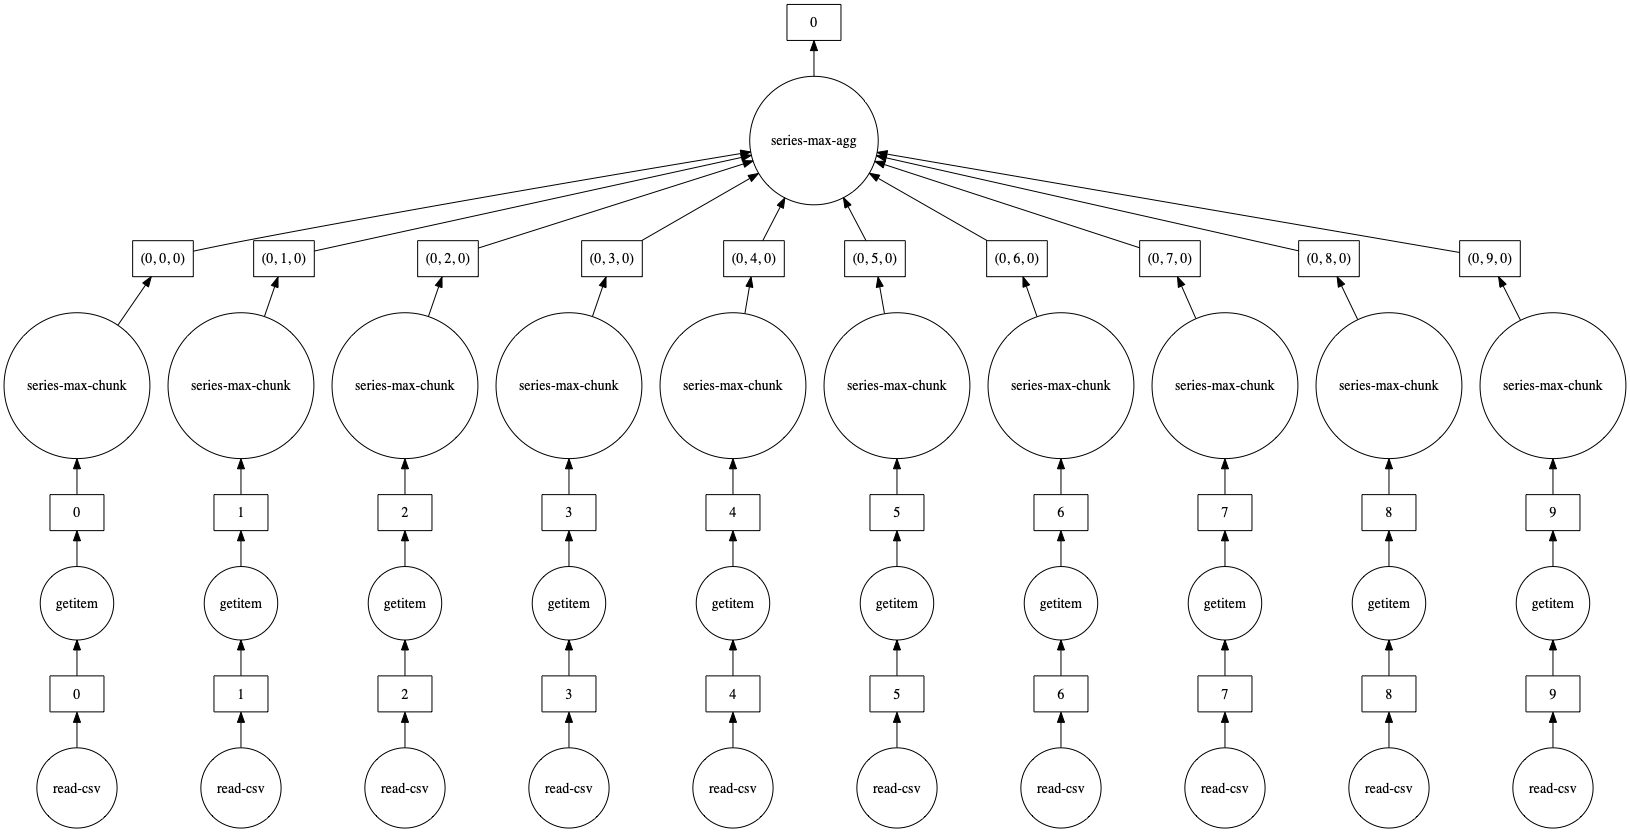

In [84]:
df.DepDelay.max().visualize()

In [85]:
len(df)

2611892

In [86]:
len(df[~df.Cancelled])

2540961

In [87]:
(df[-df.Cancelled]
 .groupby('Origin')
 .Origin
 .count()
 .compute())

Origin
EWR    1139451
JFK     427243
LGA     974267
Name: Origin, dtype: int64

In [88]:
(df
 .groupby('Origin')
 .DepDelay
 .mean()
 .compute())

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

In [89]:
(df
 .groupby('DayOfWeek')
 .DepDelay
 .mean()
 .compute())

DayOfWeek
1     8.096565
2     8.149109
3     9.141912
4    10.538275
5    11.476687
6     7.824071
7     8.994296
Name: DepDelay, dtype: float64

### Intermediate results sharing

In [90]:
%%time 
df[~df.Cancelled].DepDelay.mean().compute()
df[~df.Cancelled].DepDelay.std().compute()

CPU times: user 190 ms, sys: 22.1 ms, total: 212 ms
Wall time: 3.77 s


28.974539774551456

In [91]:
%%time 
dask.compute(df[~df.Cancelled].DepDelay.mean(), df[~df.Cancelled].DepDelay.std())

CPU times: user 110 ms, sys: 12 ms, total: 122 ms
Wall time: 1.92 s


(9.206602541321965, 28.974539774551456)

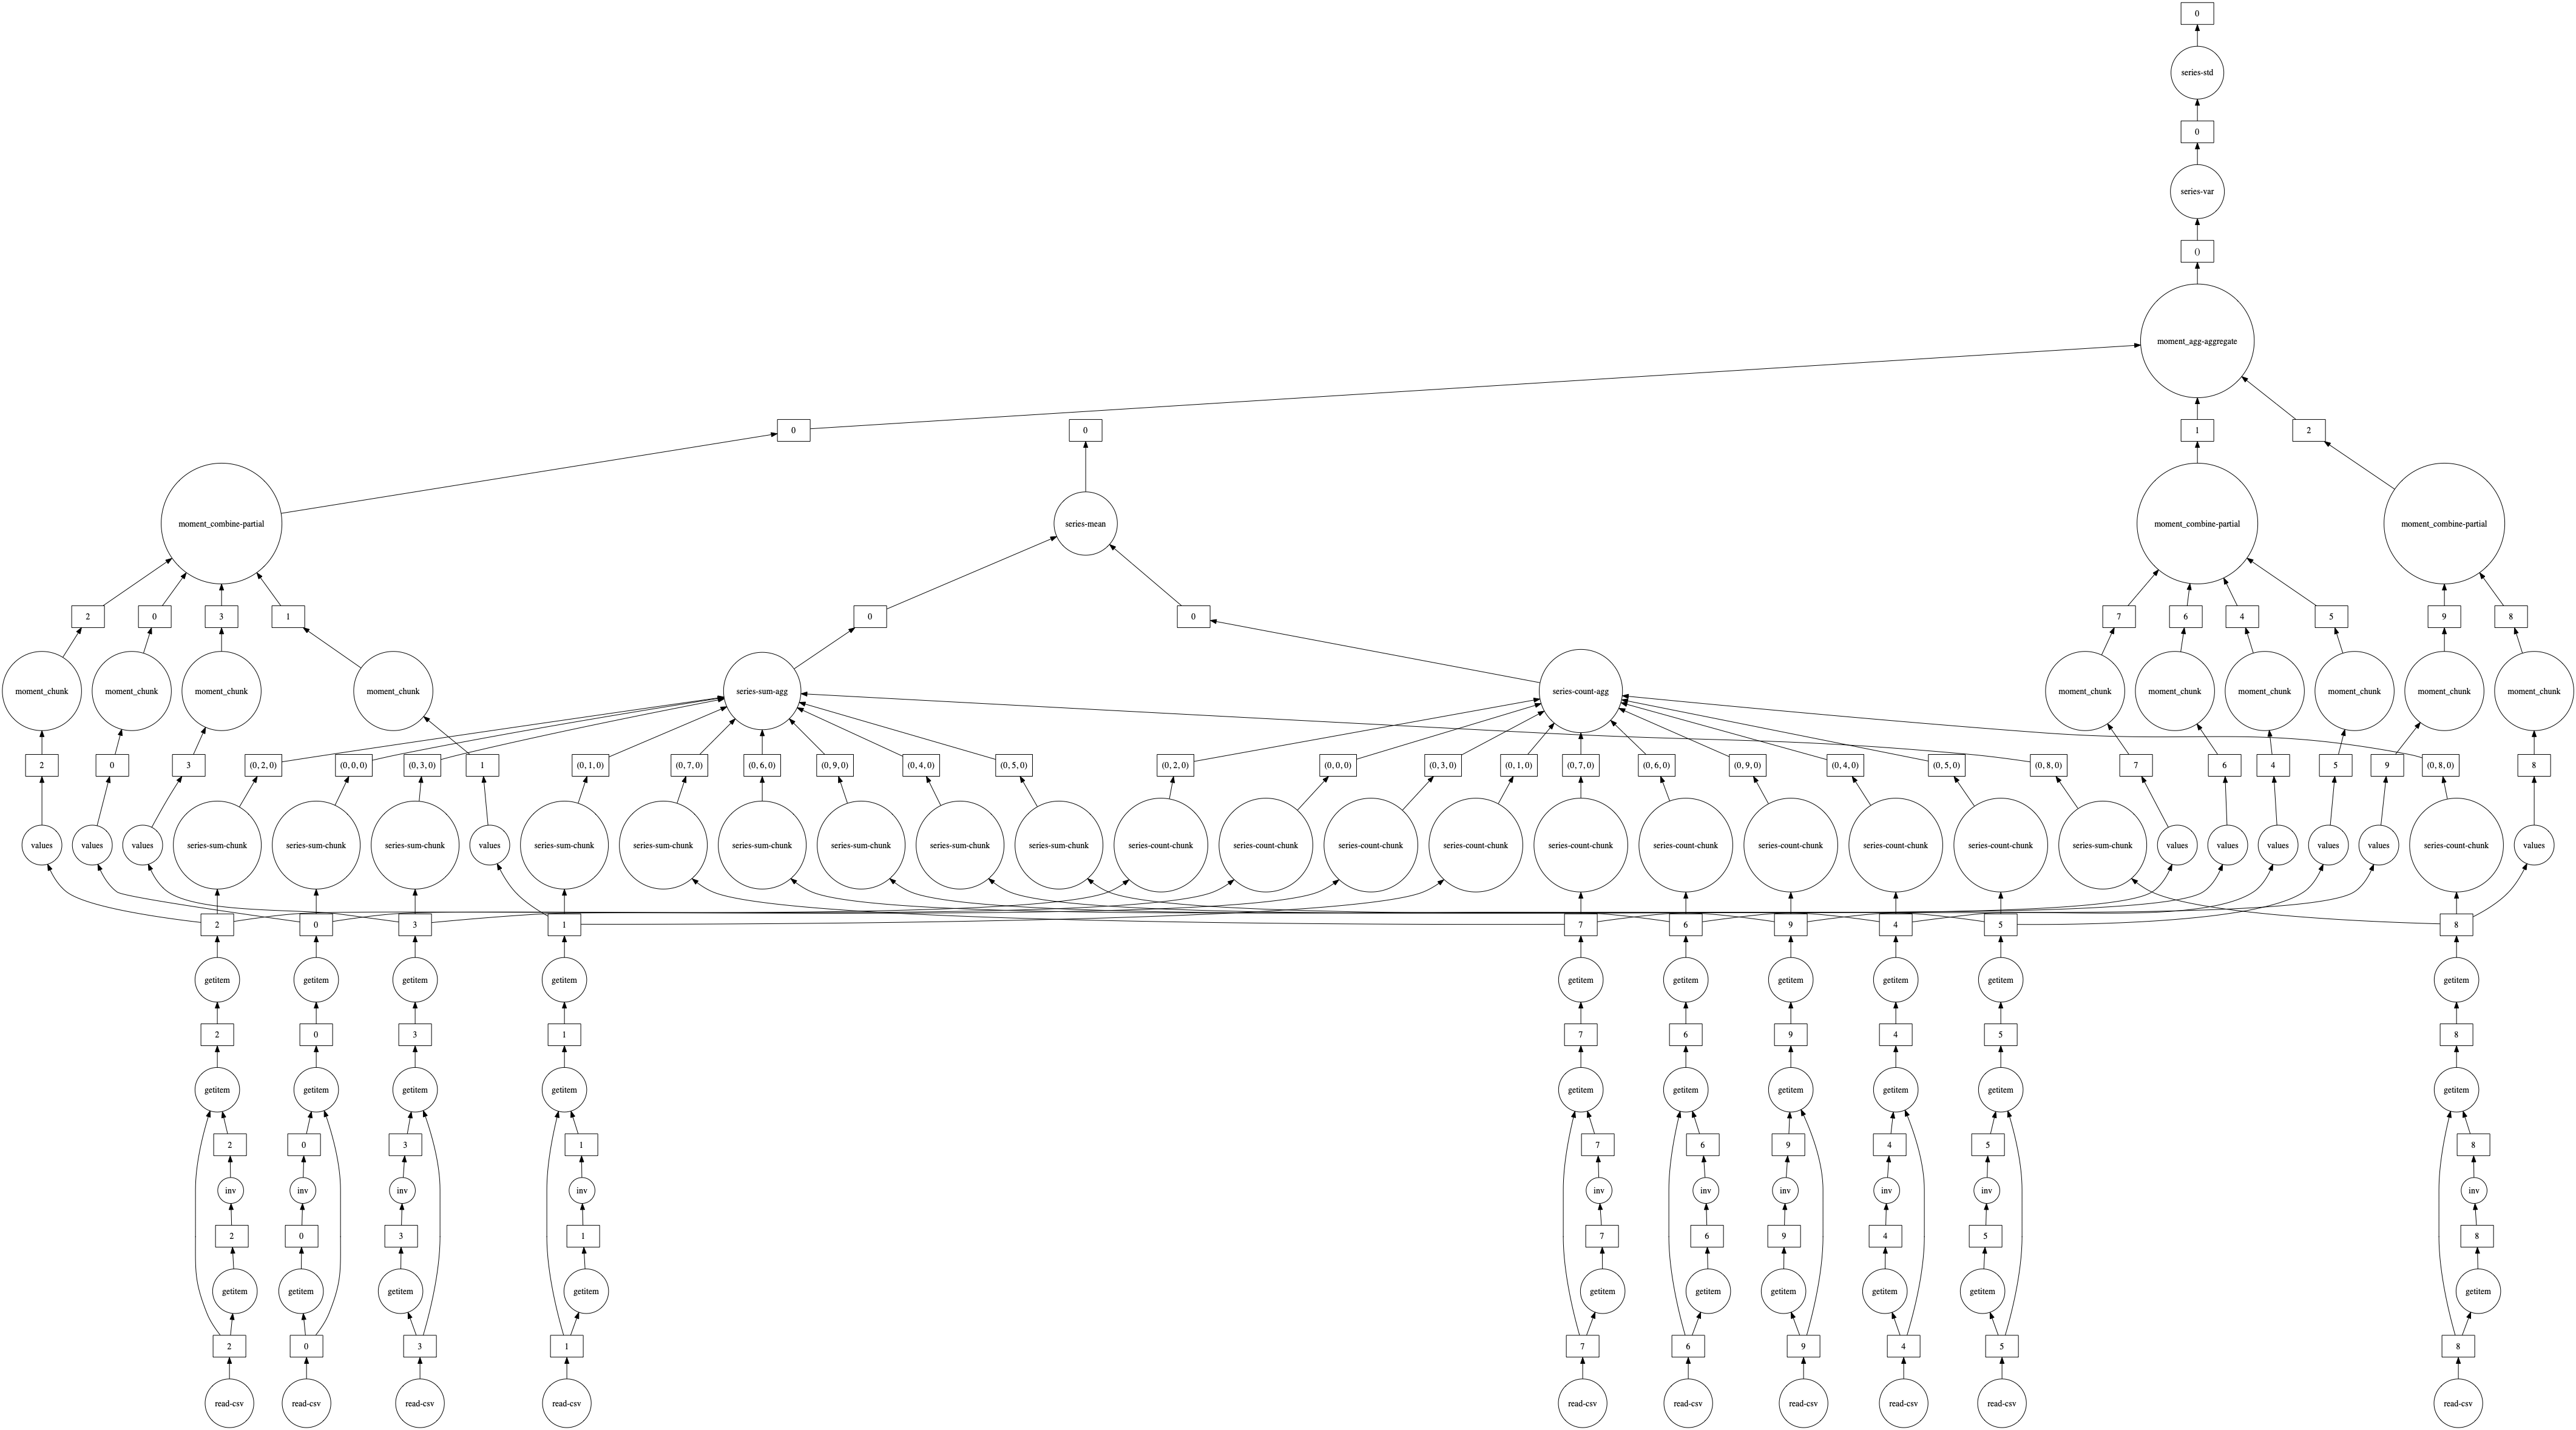

In [92]:
dask.visualize(df[~df.Cancelled].DepDelay.mean(), df[~df.Cancelled].DepDelay.std())

In [93]:
crs_dep_time = df.CRSDepTime.head(10)
crs_dep_time

0    1540
1    1540
2    1540
3    1540
4    1540
5    1540
6    1540
7    1540
8    1540
9    1540
Name: CRSDepTime, dtype: int64

In [94]:
hours = df.CRSDepTime // 100
hours_timedelta = hours.map_partitions(pd.to_timedelta, unit='h')

minutes = df.CRSDepTime % 100
minutes_timedelta = minutes.map_partitions(pd.to_timedelta, unit='m')

departure_timestamp = df.Date + hours_timedelta + minutes_timedelta

In [95]:
departure_timestamp.head()

0   1990-01-01 15:40:00
1   1990-01-02 15:40:00
2   1990-01-03 15:40:00
3   1990-01-04 15:40:00
4   1990-01-05 15:40:00
dtype: datetime64[ns]

In [96]:
client.close()

## 1.6 Distributed - distributed scheduler

In [97]:
%run prep.py -d flights

In [98]:
import dask.dataframe as dd
import os 

df = dd.read_csv(os.path.join('data', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': object,
                        'CRSElapsedTime': float,
                        'Cancelled': bool})

largest_delay = df[-df.Cancelled].groupby('Origin').DepDelay.mean().max()
largest_delay

dd.Scalar<series-..., dtype=float64>

In [99]:
import time
for sch in ['threading', 'processes', 'sync']:
    t0 = time.time()
    r = largest_delay.compute(scheduler=sch)
    t1 = time.time()
    print(f"{sch:>10}, {t1 - t0:0.4f} s; result, {r:0.2f} hours")

 threading, 3.6000 s; result, 10.35 hours
 processes, 8.3617 s; result, 10.35 hours
      sync, 5.1353 s; result, 10.35 hours


### Make a cluster

In [100]:
from dask.distributed import Client 
client = Client()
client.cluster

Task was destroyed but it is pending!
task: <Task pending name='Task-1253' coro=<HTTP1ServerConnection._server_request_loop() running at /Users/boyuan/anaconda3/envs/sds/lib/python3.8/site-packages/tornado/http1connection.py:817> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x7f80c45e2f70>()]> cb=[IOLoop.add_future.<locals>.<lambda>() at /Users/boyuan/anaconda3/envs/sds/lib/python3.8/site-packages/tornado/ioloop.py:690]>


### Execute with the distributed client

In [101]:
from dask import delayed 
import time 

def inc(x):
    time.sleep(5)
    return x + 1
def dec(x):
    time.sleep(3)
    return x - 1
def add(x, y):
    time.sleep(7)
    return x + y

In [102]:
x = delayed(inc)(1)
y = delayed(dec)(2)
total = delayed(add)(x, y)
total.compute()

3

In [103]:
%%time 
largest_delay.compute()

CPU times: user 116 ms, sys: 13 ms, total: 129 ms
Wall time: 2.18 s


10.351298909519874

In [104]:
len(df)

2611892

In [105]:
df[~df.Cancelled].groupby('Origin').DepDelay.mean().compute()

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

In [106]:
client.close()

## 1.7 Data storage

In [107]:
%run prep.py -d accounts

### csv

In [108]:
import os 
filename = os.path.join('data','accounts.*.csv')
filename

'data/accounts.*.csv'

In [109]:
import dask.dataframe as dd
df_csv = dd.read_csv(filename)
df_csv.head()

,id,names,amount
0,463,Tim,871
1,41,Bob,25
2,262,Hannah,735
3,116,Wendy,188
4,40,Quinn,1230


### HDF5

In [110]:
target = os.path.join('data','accounts.h5')
target

'data/accounts.h5'

In [111]:
%%time 
df_csv.to_hdf(target, '/data')

CPU times: user 2.6 s, sys: 274 ms, total: 2.87 s
Wall time: 2.96 s


['data/accounts.h5', 'data/accounts.h5', 'data/accounts.h5']

In [112]:
df_hdf = dd.read_hdf(target, '/data')
df_hdf.head()

,id,names,amount
0,463,Tim,871
1,41,Bob,25
2,262,Hannah,735
3,116,Wendy,188
4,40,Quinn,1230


In [113]:
%%time 
df_csv.amount.sum().compute()

CPU times: user 596 ms, sys: 159 ms, total: 755 ms
Wall time: 367 ms


2848013769

In [114]:
%%time 
df_hdf.amount.sum().compute()

CPU times: user 1.56 s, sys: 154 ms, total: 1.71 s
Wall time: 1.71 s


2848013769

### Store text data with categoricals

In [115]:
%%time 
df_hdf.categorize(columns = ['names']).to_hdf(target, '/data2')

CPU times: user 4.62 s, sys: 445 ms, total: 5.07 s
Wall time: 5.1 s


['data/accounts.h5', 'data/accounts.h5', 'data/accounts.h5']

In [116]:
df_hdf = dd.read_hdf(target, '/data2')
df_hdf.head()

,id,names,amount
0,463,Tim,871
1,41,Bob,25
2,262,Hannah,735
3,116,Wendy,188
4,40,Quinn,1230


In [117]:
%%time 
df_hdf.amount.sum().compute()

CPU times: user 124 ms, sys: 47.5 ms, total: 171 ms
Wall time: 169 ms


2848013769

### parquet

In [118]:
target = os.path.join('data','accounts.parquet')
df_csv.categorize(columns = ['names']).to_parquet(target, storage_options = {'has_nulls':True}, engine = 'fastparquet')

In [119]:
ls -l data/accounts.parquet/

total 146536
-rw-r--r--  1 boyuan  staff       927 Aug 30 14:03 _common_metadata
-rw-r--r--  1 boyuan  staff      2223 Aug 30 14:03 _metadata
-rw-r--r--  1 boyuan  staff  25002085 Aug 30 14:03 part.0.parquet
-rw-r--r--  1 boyuan  staff  25002085 Aug 30 14:03 part.1.parquet
-rw-r--r--  1 boyuan  staff  25002085 Aug 30 14:03 part.2.parquet


In [120]:
df_p = dd.read_parquet(target)
df_p.dtypes

id           int64
names     category
amount       int64
dtype: object

In [121]:
%%time 
df_p.amount.sum().compute()

CPU times: user 137 ms, sys: 49.4 ms, total: 186 ms
Wall time: 147 ms


2848013769

### remote files

In [122]:
%%script echo skipping 
dd.read_csv('s3://nyc-tlc/trip data/yellow_tripdata_2015-*.csv',
            storage_options={'anon': True})

skipping


## 1.8 Machine learning

### sklearn

In [123]:
from sklearn.datasets import make_classification

In [124]:
X, y = make_classification(n_samples = 10000, n_features = 4, random_state = 0)
X[:8]

array([[-0.77244139,  0.3607576 , -2.38110133,  0.08757   ],
       [ 1.14946035,  0.62254594,  0.37302939,  0.45965795],
       [-1.90879217, -1.1602627 , -0.27364545, -0.82766028],
       [-0.77694695,  0.31434299, -2.26231851,  0.06339125],
       [-1.17047054,  0.02212382, -2.17376797, -0.13421976],
       [ 0.79010037,  0.68530624, -0.44740487,  0.44692959],
       [ 1.68616989,  1.6329131 , -1.42072654,  1.04050557],
       [-0.93912893, -1.02270838,  1.10093827, -0.63714432]])

In [125]:
from sklearn.svm import SVC

In [126]:
estimator = SVC(random_state = 0)
estimator.fit(X, y)

SVC(random_state=0)

In [127]:
estimator.support_vectors_[:4]

array([[-0.77244139,  0.3607576 , -2.38110133,  0.08757   ],
       [ 1.14946035,  0.62254594,  0.37302939,  0.45965795],
       [-0.77694695,  0.31434299, -2.26231851,  0.06339125],
       [ 0.79010037,  0.68530624, -0.44740487,  0.44692959]])

In [128]:
estimator.score(X, y)

0.905

In [129]:
estimator = SVC(C = 0.00001, shrinking = False, random_state = 0)
estimator.fit(X, y)
estimator.support_vectors_[:4]

array([[-0.77244139,  0.3607576 , -2.38110133,  0.08757   ],
       [ 1.14946035,  0.62254594,  0.37302939,  0.45965795],
       [-0.77694695,  0.31434299, -2.26231851,  0.06339125],
       [-1.17047054,  0.02212382, -2.17376797, -0.13421976]])

In [130]:
estimator.score(X, y)

0.5007

In [131]:
from sklearn.model_selection import GridSearchCV

In [132]:
%%time 
estimator = SVC(gamma = 'auto', random_state = 0, probability = True)
param_grid = {
    'C':[0.001, 10.0],
    'kernel':['rbf','poly']
}
grid_search = GridSearchCV(estimator, param_grid, verbose = 2, cv = 2)
grid_search.fit(X, y)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] C=0.001, kernel=rbf .............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.001, kernel=rbf, total=   2.6s
[CV] C=0.001, kernel=rbf .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


[CV] .............................. C=0.001, kernel=rbf, total=   2.5s
[CV] C=0.001, kernel=poly ............................................
[CV] ............................. C=0.001, kernel=poly, total=   1.2s
[CV] C=0.001, kernel=poly ............................................
[CV] ............................. C=0.001, kernel=poly, total=   1.2s
[CV] C=10.0, kernel=rbf ..............................................
[CV] ............................... C=10.0, kernel=rbf, total=   0.7s
[CV] C=10.0, kernel=rbf ..............................................
[CV] ............................... C=10.0, kernel=rbf, total=   0.7s
[CV] C=10.0, kernel=poly .............................................
[CV] .............................. C=10.0, kernel=poly, total=   1.5s
[CV] C=10.0, kernel=poly .............................................
[CV] .............................. C=10.0, kernel=poly, total=   1.4s


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   11.9s finished


CPU times: user 14.5 s, sys: 237 ms, total: 14.7 s
Wall time: 14.7 s


GridSearchCV(cv=2,
             estimator=SVC(gamma='auto', probability=True, random_state=0),
             param_grid={'C': [0.001, 10.0], 'kernel': ['rbf', 'poly']},
             verbose=2)

In [133]:
%%time 
grid_search = GridSearchCV(estimator, param_grid, verbose = 2, cv = 2, n_jobs = -1)
grid_search.fit(X, y)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    3.1s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    4.6s finished


CPU times: user 2.82 s, sys: 147 ms, total: 2.97 s
Wall time: 7.5 s


GridSearchCV(cv=2,
             estimator=SVC(gamma='auto', probability=True, random_state=0),
             n_jobs=-1,
             param_grid={'C': [0.001, 10.0], 'kernel': ['rbf', 'poly']},
             verbose=2)

### Multi-machine parallelism 

In [134]:
import joblib 
import dask.distributed 
c = dask.distributed.Client()

In [135]:
param_grid = {
    'C':[0.001, 0.1, 1.0, 2.5, 5, 10.0]
}
grid_search = GridSearchCV(estimator, param_grid, verbose = 2, cv = 5, n_jobs = -1)

In [136]:
%%time 
with joblib.parallel_backend('dask', scatter = [X, y]):
    grid_search.fit(X, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   23.7s finished


CPU times: user 3.88 s, sys: 210 ms, total: 4.09 s
Wall time: 26.7 s


### Training on large datasets

In [137]:
import dask.array as da
import dask.delayed 
from sklearn.datasets import make_blobs
import numpy as np 

In [138]:
n_centers = 12
n_features = 20

X_small, y_small = make_blobs(n_samples = 1000, centers = n_centers, n_features = n_features, random_state = 0)
centers = np.zeros((n_centers, n_features))

for i in range(n_centers):
    centers[i] = X_small[y_small == i].mean(0)

centers[:4]

array([[ 1.00796679,  4.34582168,  2.15175661,  1.04337835, -1.82115164,
         2.81149666, -1.18757701,  7.74628882,  9.36761449, -2.20570731,
         5.71142324,  0.41084221,  1.34168817,  8.4568751 , -8.59042755,
        -8.35194302, -9.55383028,  6.68605157,  5.34481483,  7.35044606],
       [ 9.49283024,  6.1422784 , -0.97484846,  5.8604399 , -7.61126963,
         2.86555735, -7.25390288,  8.89609285,  0.33510318, -1.79181328,
        -4.66192239,  5.43323887, -0.86162507,  1.3705568 , -9.7904172 ,
         2.3613231 ,  2.20516237,  2.20604823,  8.76464833,  3.47795068],
       [-2.67206588, -1.30103177,  3.98418492, -8.88040428,  3.27735964,
         3.51616445, -5.81395151, -7.42287114, -3.73476887, -2.89520363,
         1.49435043, -1.35811028,  9.91250767, -7.86133474, -5.78975793,
        -6.54897163,  3.08083281, -5.18975209, -0.85563107, -5.06615534],
       [-6.85980599, -7.87144648,  3.33572279, -7.00394241, -5.97224874,
        -2.55638942,  6.36329802, -7.97988653,  

In [139]:
n_samples_per_block = 10000
n_blocks = 500

delayeds = [dask.delayed(make_blobs)(n_samples = n_samples_per_block,
                                     centers = centers,
                                     n_features = n_features,
                                     random_state = i)[0]
            for i in range(n_blocks)]
arrays = [da.from_delayed(obj, shape = (n_samples_per_block, n_features), dtype = X.dtype)
          for obj in delayeds]
X = da.concatenate(arrays)
X

,Array,Chunk
Bytes,800.00 MB,1.60 MB
Shape,"(5000000, 20)","(10000, 20)"
Count,2000 Tasks,500 Chunks
Type,float64,numpy.ndarray


In [140]:
X = X.persist()

In [141]:
from dask_ml.cluster import KMeans 

In [142]:
clf = KMeans(init_max_iter = 3, oversampling_factor = 10)

In [143]:
%%time 
clf.fit(X)

CPU times: user 18.4 s, sys: 774 ms, total: 19.1 s
Wall time: 26.7 s


KMeans(init_max_iter=3, oversampling_factor=10)

In [144]:
clf.labels_

,Array,Chunk
Bytes,20.00 MB,40.00 kB
Shape,"(5000000,)","(10000,)"
Count,3000 Tasks,500 Chunks
Type,int32,numpy.ndarray


In [146]:
clf.labels_[:10].compute()

array([1, 0, 5, 3, 4, 5, 4, 1, 6, 4], dtype=int32)